# CW11 - GUI paper exploration - LD

Discard: Explorative 

In [1]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch
import swyft
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType
from scipy import ndimage

## Model

In [13]:
N = 20  # Number of data bins
SIGMA = 0.02  # Measurement uncertainty

In [14]:
def model(v):
    return dict(x=v)
    
# Noise model
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise)

# Prior
def transform(u):
    return u

### Zoom in

In [15]:
sim = swyft.Simulator(model, N, dict(x=(N,)))

In [16]:
prior = swyft.Prior(transform, N, n = 1000)

In [32]:
NTRAIN = 1000

In [33]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.
Store: Adding 1039 new samples to simulator store.


In [34]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

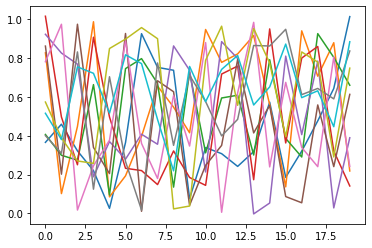

In [35]:
for i in range(10):
    plt.plot(dataset[i][0]['x'])

In [36]:
post = swyft.Posteriors(dataset)
#partition = (tuple(range(N)),)
partition = range(N)
post.add(partition, device='cuda')#, tail_args = dict(hidden_layers = [1024, 1024, 1024]))

In [45]:
post.train(partition, max_epochs = 20, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 128, optimizer_args = dict(lr = 0.01))

Training: lr=0.0025, Epoch=13, VL=11.52, TL=5.006


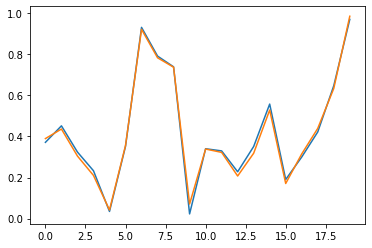

In [46]:
obs0, v0, u0 = dataset[0]
plt.plot(obs0['x'])
plt.plot(v0[:])

In [47]:
p0 = list(post._ratios.keys())[0]

In [48]:
tail = post._ratios[p0].tail
head = post._ratios[p0].head
f = head(dict(x = torch.tensor(obs0['x']).unsqueeze(0).float().cuda()))

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
nbatch = 100
o = dict(x = torch.tensor(obs0['x']).unsqueeze(0).repeat(nbatch,1).float().cuda())
f = head(o)

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [50]:
u_fit = torch.rand(nbatch, N).cuda()
u_fit.shape

torch.Size([100, 20])

In [51]:
us = []
for _ in range(1000):
    us.append(u_fit.detach().cpu())
    u_fit.requires_grad = True
    r = tail(f, u_fit)
    r = torch.minimum(r, r*0.+0)
    loss = -sum(sum(r))
    #print(loss.shape)
    loss.backward()
    #print(loss)
    epsilon = 1e-4
    u_fit = u_fit - epsilon * u_fit.grad
    u_fit = u_fit.detach()
    u_fit = torch.maximum(u_fit, u_fit*0.)
    u_fit = torch.minimum(u_fit, u_fit*0.+1.)
    

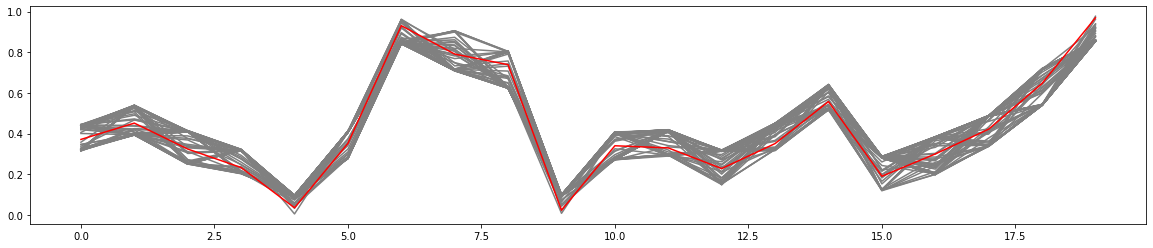

In [52]:
plt.figure(figsize=(20,4))
plt.plot(u_fit.cpu().numpy().T, color='0.5')
plt.plot(obs0['x'], color='r')

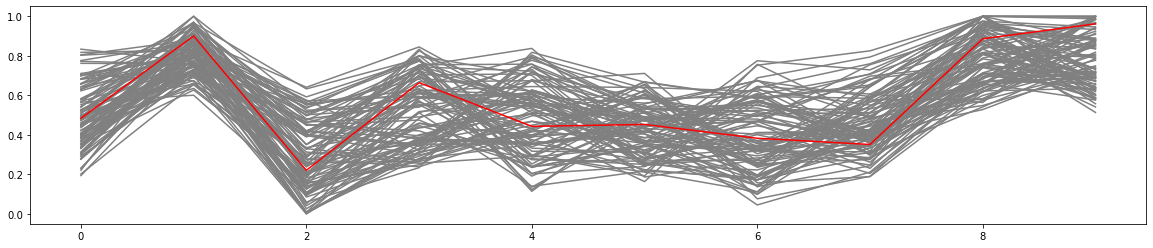

In [123]:
plt.figure(figsize=(20,4))
plt.plot(u_fit.cpu().numpy().T, color='0.5')
plt.plot(obs0['x'], color='r')